In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.integrate import nquad, dblquad, tplquad
from scipy.optimize import minimize_scalar, fsolve, brentq
from scipy.integrate import quad
from math import erf

from pathos.multiprocessing import ProcessingPool as Pool
from functools import partial

from scipy.interpolate import interp1d, interp2d, RegularGridInterpolator
from tqdm import tqdm
# from multiprocessing import Pool
from pathos.multiprocessing import ProcessingPool as Pool
import functools
import pickle
from abc import ABC, abstractmethod

from LensCalcPy.survey import *
from LensCalcPy.lens import *   
from LensCalcPy.pbh import *
from LensCalcPy.utils import *
from LensCalcPy.galaxy import *
from LensCalcPy.parameters import *

from fastcore.test import *

%load_ext autoreload
%autoreload 2

In [8]:
plt.style.use("style.mplstyle")
sns.set_palette("colorblind")


In [52]:
class Nfw(Lens):
    """A class to represent a PBH population"""

    def __init__(self,
                mass: float, # PBH mass in solar masses
                mw_model=None,
                l = None,
                b = None,
                ds = 770,
                ut_interp = None,
                R90 = None,
                u_t = 1,
                rS = 1,
                ):
        """
        Initialize the PBH population
        """

        self.mw_model = mw_model or MilkyWayModel(mw_parameters)
        self.m31_model = M31Model(m31_parameters)
        
        if l is None:
            raise ValueError("Galactic longitude must be specified")
        if b is None:
            raise ValueError("Galactic latitude must be specified")
        self.l = l
        self.b = b

        self.mass = mass
        self.ut_interp = ut_interp
        self.ds = ds
        self.R90 = R90 #radius of 90% of the mass of the halo in kpc
        self.u_t = u_t #upper limit of u
        self.rS = rS #scale radius in solar radii
    
    def __str__(self) -> str:
        return f"NFW population with mass={self.mass}"
    __repr__ = __str__


    def _rho_func(self, m, d):
        return rho_func(m, d, self.ds) * self.rS #rS in solar radii

    def umin_upper_bound(self, d, m=None):
        if m is None:
            m = self.mass
        rho = self._rho_func(m, d)
        eR = einstein_rad(d, m, self.ds)
        # return u_t_nfw(rho, self.R90/eR)
        return u_t_nfw_101(rho, self.R90/eR)

        
    def differential_rate_total(self, t, finite=True):
        return self.differential_rate_mw(t, finite=finite) + self.differential_rate_m31(t, finite=finite)
 
    def compute_differential_rate(self, ts, finite=False):
        return [self.differential_rate_total(t, finite=finite) for t in ts]

    def d_upper_bound(self, m=None):
        if m is None:
            m = self.mass
        #Determine upper limit for d otherwise for low masses, the contribution which only comes from d << 1 gets missed
        d_arr = np.logspace(-3, np.log10(self.ds*0.99), 100)
        for d in d_arr:
            if self.umin_upper_bound(d,m=m) == 0:
                return d
        return self.ds
    
    def differential_rate_integrand_new(self, umin, d, model, tmin=0.07, tmax=3, finite=False, v_disp=None, t_fwhm=False):

        #Analytically perform integral over t
        r = model.dist_center(d, self.l, self.b)
        ut = self.umin_upper_bound(d) if finite else self.u_t
        if ut <= umin:
            return 0
        if v_disp is None: 
            # v_disp = model.velocity_dispersion_dm(r)
            v_disp = model.velocity_dispersion_nfw(r)
        
        # if t_fwhm:
            # ut = u_fwhm_interp([rho_func(self.mass, d, self.ds), umin])[0]
            # ut = self.ut_interp(self._rho_func(self.mass, d), umin)

        A = 2/(ut**2 - umin**2)**0.5 * model.density_dm(d, self.l, self.b) / (self.mass * (v_disp*htosec)**2 ) * (2 * einstein_rad(d, self.mass, self.ds)* (ut**2 - umin**2)**0.5)**4 * kpctokm**2
        B = (2*einstein_rad(d, self.mass, self.ds) * kpctokm * (ut**2 - umin**2)**0.5)**2 / (v_disp*htosec)**2

        def integral_t(t):
            return A/(2*B) * (np.exp(-B/t**2 )/t - np.pi**(1/2) * erf(B**(1/2)/t) /(2* B**(1/2)))

        return integral_t(tmax) - integral_t(tmin)

    def rate_total_new(self, integrand_func, finite=True, tcad=0.07, tobs=3, epsabs = 1.49e-08, epsrel = 1.49e-08, efficiency=None):      

        # Innermost integral over t
        if efficiency is None:
            def inner_integrand(u, d):
                return integrand_func(u, d, tmin=tcad, tmax=tobs)
        else:
            t_arr = np.logspace(np.log10(tcad), np.log10(tobs), 10) #Evaluate the efficiency at 10 logarithmic points between tcad and tobs
            t_mins = t_arr[:-1]
            t_maxs = t_arr[1:]
            def inner_integrand(u, d):
                return np.sum([integrand_func(u, d, tmin=tmin, tmax=tmax) * efficiency((tmin*tmax)**(1/2)) for tmin, tmax in zip(t_mins, t_maxs)]) #use geometric mean of tmin and tmax to evaluate efficiency
            
        # Second integral (over u) - bounds given by d
        def second_integral(d):
            u_min, u_max = 0, self.umin_upper_bound(d)
            result, error = quad(inner_integrand, u_min, u_max, args=(d), epsabs=epsabs, epsrel=epsrel) 

            return result
        
        # Outermost integral (over d)
        # d_min, d_max = 0, self.d_upper_bound() if finite else self.ds
        d_min, d_max = 0, self.ds

        result, error = quad(second_integral, d_min, d_max, epsabs=epsabs, epsrel=epsrel)
        return result  
    
    def rate_mw_new(self, finite=True, tcad = 0.07, tobs = 3, efficiency=None, epsabs = 1.49e-08, epsrel = 1.49e-08, t_fwhm=False, v_disp=None):
        def integrand_func(umin, d, tmin, tmax):
            return self.differential_rate_integrand_new(umin, d, self.mw_model, tmin, tmax, finite=finite, t_fwhm=t_fwhm, v_disp=v_disp)
        return self.rate_total_new(integrand_func, finite=finite, tcad=tcad, tobs=tobs, efficiency=efficiency, epsabs=epsabs, epsrel=epsrel)
    
    def rate_m31_new(self, finite=True, tcad = 0.07, tobs = 3, efficiency=None, epsabs = 1.49e-08, epsrel = 1.49e-08, t_fwhm=False, v_disp=None):
        def integrand_func(umin, d, tmin, tmax):
            return self.differential_rate_integrand_new(umin, d, self.m31_model, tmin, tmax, finite=finite, t_fwhm=t_fwhm, v_disp=v_disp)
        return self.rate_total_new(integrand_func, finite=finite, tcad=tcad, tobs=tobs, efficiency=efficiency, epsabs=epsabs, epsrel=epsrel)
    


In [478]:
rho_func(1.818e-10, 1, 8.5)

15.20758807032295

In [467]:
def Mcut(Amax, d, Rs, ds):
    return (Amax**2-1)*d*(Rs*rsolkpc)**2*c**2/(16* ds**2 *G)
    # return (-d * Rs**2 + Amax**2 * d * Rs**2)/(16 * c**2 * ds**2 * G)

In [476]:
Mcut(1.01, 1, 1, 8.5)

1.817888876036051e-10

In [327]:
def _rho_func(m, d, ds, rS = 1):
    return rho_func(m, d, ds) * rS #rS in solar radii

def umin_upper_bound(d, m, ds, R90, u_t_func):
    rho = _rho_func(m, d, ds, rS = 1)
    eR = einstein_rad(d, m, ds)
    return u_t_func(rho, R90/eR)

        
def d_upper_bound(m, ds, R90, ut_func):
    #Determine upper limit for d otherwise for low masses, the contribution which only comes from d << 1 gets missed
    d_arr = np.logspace(-3, np.log10(ds*0.99), 100)
    for d in d_arr:
        if umin_upper_bound(d,m, ds, R90, ut_func) == 0:
            return d
    return ds
    
def differential_rate_integrand_new(umin, d, model, l, b, mass, ds, R90, u_t_func, tmin=0.07, tmax=3, finite=False, v_disp=None):
    # Calculate distance to galaxy center
    r = model.dist_center(d, l, b)
    
    # Calculate upper bound for minimum impact parameter
    ut = umin_upper_bound(d, mass, ds, R90, u_t_func) 
    if ut <= umin:
        return 0

    # Calculate velocity dispersion if not provided
    if v_disp is None: 
        v_disp = model.velocity_dispersion_nfw(r)

    # Calculate factors for integral over t
    einstein_radius = einstein_rad(d, mass, ds)
    density_dm = model.density_dm(d, l, b)
    A = 2/(ut**2 - umin**2)**0.5 * density_dm / (mass * (v_disp*htosec)**2 ) * (2 * einstein_radius * (ut**2 - umin**2)**0.5)**4 * kpctokm**2
    B = (2*einstein_radius * kpctokm * (ut**2 - umin**2)**0.5)**2 / (v_disp*htosec)**2

    # Define integral over t
    def integral_t(t):
        return A/(2*B) * (np.exp(-B/t**2 )/t - np.pi**(1/2) * erf(B**(1/2)/t) /(2* B**(1/2)))

    # Return difference of integral at tmax and tmin
    return integral_t(tmax) - integral_t(tmin)

def rate_total_new(integrand_func, mass, ds, R90, u_t_func, finite=True, tcad=0.07, tobs=3, epsabs = 1.49e-08, epsrel = 1.49e-08, efficiency=None):      

    # Innermost integral over t
    if efficiency is None:
        def inner_integrand(u, d):
            return integrand_func(u, d, tmin=tcad, tmax=tobs)
    else:
        t_arr = np.logspace(np.log10(tcad), np.log10(tobs), 10) #Evaluate the efficiency at 10 logarithmic points between tcad and tobs
        t_mins = t_arr[:-1]
        t_maxs = t_arr[1:]
        def inner_integrand(u, d):
            return np.sum([integrand_func(u, d, tmin=tmin, tmax=tmax) * efficiency((tmin*tmax)**(1/2)) for tmin, tmax in zip(t_mins, t_maxs)]) #use geometric mean of tmin and tmax to evaluate efficiency
        
    # Second integral (over u) - bounds given by d
    def second_integral(d):
        u_min, u_max = 0, umin_upper_bound(d, mass, ds, R90, u_t_func)
        result, error = quad(inner_integrand, u_min, u_max, args=(d), epsabs=epsabs, epsrel=epsrel) 

        return result
    
    # Outermost integral (over d)
    # d_min, d_max = 0, self.d_upper_bound() if finite else self.ds
    d_min, d_max = 0, ds

    result, error = quad(second_integral, d_min, d_max, epsabs=epsabs, epsrel=epsrel)
    return result  
    
def rate_mw_new(mass, ds, l, b, R90, u_t_func, finite=True, tcad = 0.07, tobs = 3, efficiency=None, epsabs = 1.49e-08, epsrel = 1.49e-08, v_disp=None):
    def integrand_func(umin, d, tmin, tmax):
        return differential_rate_integrand_new(umin, d, MilkyWayModel(mw_parameters), l, b, mass, ds, R90, u_t_func, tmin, tmax, finite=finite, v_disp=v_disp)
    return rate_total_new(integrand_func, mass, ds, R90, u_t_func, finite=finite, tcad=tcad, tobs=tobs, efficiency=efficiency, epsabs=epsabs, epsrel=epsrel)

def rate_m31_new(mass, ds, l, b, R90, finite=True, tcad = 0.07, tobs = 3, efficiency=None, epsabs = 1.49e-08, epsrel = 1.49e-08, v_disp=None):
    def integrand_func(umin, d, tmin, tmax):
        return differential_rate_integrand_new(umin, d, M31Model(m31_parameters), l, b, mass, ds, R90, u_t_func, tmin, tmax, finite=finite, v_disp=v_disp)
    return rate_total_new(integrand_func, mass, ds, R90, u_t_func, finite=finite, tcad=tcad, tobs=tobs, efficiency=efficiency, epsabs=epsabs, epsrel=epsrel)



In [352]:
d_arr = np.logspace(-3, np.log10(8.5*0.99), 100)
e_r_arr = np.array([einstein_rad(d, m_arr[-1], 8.5) for d in d_arr])

In [362]:
r90_max_arr = np.zeros_like(m_arr)
r90_min_arr = np.zeros_like(m_arr)

for i, m in enumerate(m_arr):
    e_r_arr = np.array([einstein_rad(d, m, 8.5) for d in d_arr])
    r90_max_arr[i] = np.max(R90_values_dressed_expected[i]/e_r_arr)
    r90_min_arr[i] = np.min(R90_values_dressed_expected[i]/e_r_arr)



Text(0.5, 1.0, 'Expected Dressed PBH')

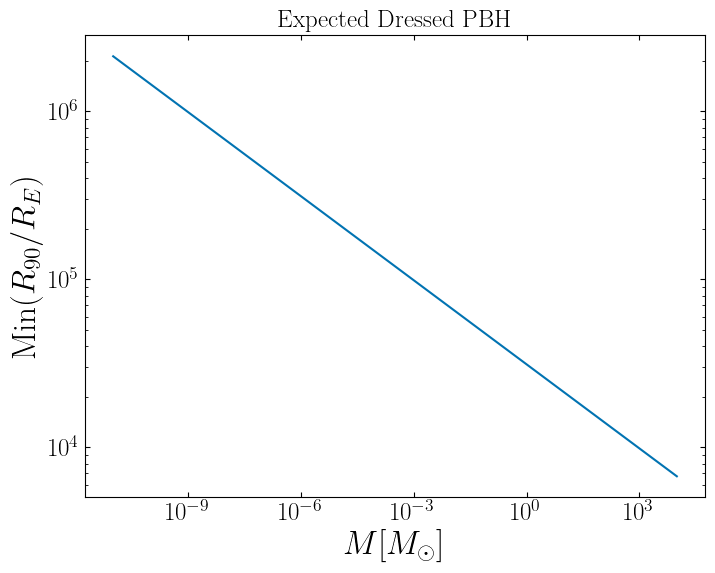

In [366]:
plt.loglog(m_arr, r90_min_arr)

plt.xlabel(r"$M [M_\odot]$")
plt.ylabel(r"Min($R_{90}/R_E$)")
plt.title("Expected Dressed PBH")

In [4]:
r90_vals_dressed = np.round(np.logspace(-1, np.log10(300), 50),2)
r90_vals_nfw = np.round(np.logspace(-1, np.log10(1000), 50),2)
r90_vals_axion = np.round(np.logspace(-1, np.log10(40), 50),2)

In [5]:
roman_df = pd.read_csv('roman_sensitivity.csv', header=None, names=['t_e [days]', 'efficiency'])
roman_efficiency_interp = interp1d(roman_df['t_e [days]'], roman_df['efficiency'])
def roman_efficiency(t):
    '''
    Takes in crossing time in hours and returns the efficiency of Roman
    '''
    t_day = t/24
    if t_day <= np.min(roman_df['t_e [days]']):
        return roman_df['efficiency'][0]
    if t_day >= np.max(roman_df['t_e [days]']):
        return roman_df['efficiency'][len(roman_df)-1]
    return(roman_efficiency_interp(t_day))

def fake_effieiency(t):
    return 1

In [6]:
# params = {"l": 1.0, "b": -1.03, "source_dist": 8.5, "obs_time": 6*72*24, "cadence": 15/60,  "n_sources": 2.4e8, "efficiency": 1, "A_t": 1.34, "survey_area":0}
rsolkpc = 2.25e-11
params = {"l": 1.0, "b": -1.03, "source_dist": 8.5, "obs_time": 6*72*24, "cadence": 15/60,  "n_sources": 2.4e8, "efficiency": 1, "A_t": 1.34, "survey_area":0}

In [31]:
R90_test = r90_vals_nfw[10]
m_test = 1e-8
print(rate_mw_new(m_test, params['source_dist'], params['l'], params['b'], R90_test*rsolkpc, u_t_nfw, tcad=params['cadence'], tobs=params['obs_time'], efficiency=None, epsabs=0, epsrel=1e-1))
print(rate_mw_new(m_test, params['source_dist'], params['l'], params['b'], R90_test*rsolkpc, u_t_nfw, tcad=params['cadence'], tobs=params['obs_time'], efficiency=None, epsabs=0, epsrel=1e-1))

# print(nfw.rate_mw_new(tcad=params['cadence'], tobs=params['obs_time'], efficiency=fake_effieiency, epsabs=0, epsrel=1e-1))

1.655346453341097e-10
4.545648836200719e-11


## Extended Sources

### NFW

In [9]:
def calculate_rate(m, R90, u_t_func):
    # return rate_mw_new(m, params['source_dist'], params['l'], params['b'], R90*rsolkpc, u_t_func, tcad=params['cadence'], tobs=params['obs_time'], efficiency=roman_efficiency, epsabs=0, epsrel=1e-1)
    return rate_mw_new(m, params['source_dist'], params['l'], params['b'], R90*rsolkpc, u_t_func, tcad=params['cadence'], tobs=params['obs_time']*100, efficiency=roman_efficiency, epsabs=0, epsrel=1e-1)

In [10]:
m_arr = np.logspace(-11, 4, 100)

R90_values = [0.1, 10, 100]
rate_dict_e = {}

for R90 in tqdm(R90_values):
    func = partial(calculate_rate, R90=R90, u_t_func=u_t_nfw)
    with Pool() as pool:
        rate_arr = np.array(pool.map(func, m_arr))
    
    rate_dict_e[R90] = rate_arr

100%|██████████| 3/3 [03:14<00:00, 64.83s/it]


In [11]:
m_arr = np.logspace(-11, 4, 100)

rate_dict_e_101 = {}

for R90 in tqdm(R90_values):
    func = partial(calculate_rate, R90=R90, u_t_func=u_t_nfw_101)
    with Pool() as pool:
        rate_arr = np.array(pool.map(func, m_arr))
    rate_dict_e_101[R90] = rate_arr

100%|██████████| 3/3 [03:11<00:00, 63.70s/it]


In [12]:
def fdm_constraint(rate, obs_time, n_sources):
    fdm = 3.0 / (rate*obs_time*n_sources)
    return np.where(fdm==np.inf, 1e3, fdm)

In [13]:
fdm_dict_e = {}

for r90, rate_arr in rate_dict_e.items():
    fdm_arr = fdm_constraint(rate_arr, params['obs_time'], params['n_sources'])
    fdm_dict_e[r90] = fdm_arr

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_67666/614136275.py:2: RuntimeWarning: divide by zero encountered in divide
  fdm = 3.0 / (rate*obs_time*n_sources)


In [14]:
fdm_dict_e_101 = {}

for r90, rate_arr in rate_dict_e_101.items():
    fdm_arr = fdm_constraint(rate_arr, params['obs_time'], params['n_sources'])
    fdm_dict_e_101[r90] = fdm_arr

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_67666/614136275.py:2: RuntimeWarning: divide by zero encountered in divide
  fdm = 3.0 / (rate*obs_time*n_sources)


In [15]:
color_dict = {0.1: 'C0', 1: 'C1', 5: 'C2', 10: 'C3', 20: 'C4', 50: 'C5', 100: 'C6'}

In [51]:
r90_01_df = pd.read_csv('extended_dat/r90_01.csv', header=None)
r90_100_df = pd.read_csv('extended_dat/r90_100.csv', header=None)

def plot_existing_limits(ax=None):
    if not ax:
        ax = plt.gca()
    ax.fill_between(r90_01_df[0], r90_01_df[1], 1, alpha=0.2, color=color_dict[0.1])
    ax.fill_between(r90_100_df[0], r90_100_df[1], 1, alpha=0.2, color=color_dict[100])
    # plt.fill_between(r90_01_df[0], r90_01_df[1], 1, alpha=0.2, color=color_dict[0.1])
    # plt.fill_between(r90_100_df[0], r90_100_df[1], 1, alpha=0.2, color=color_dict[100])
    

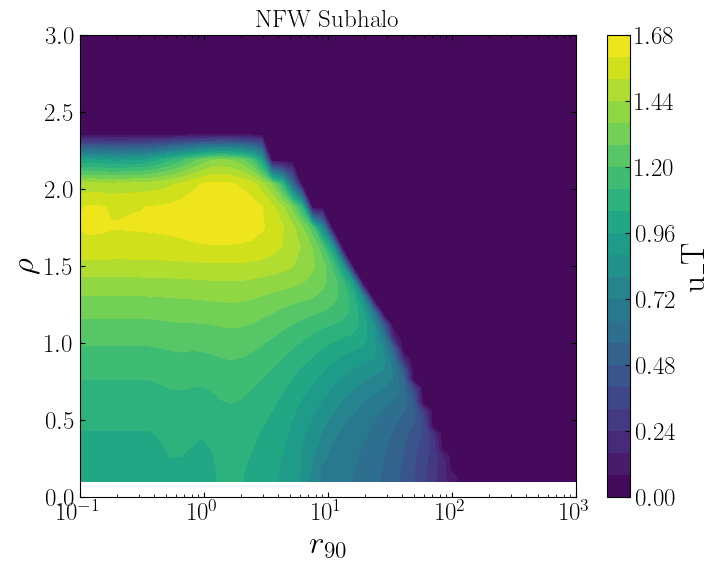

In [112]:
u_T_values_nfw = np.zeros((len(rho_arr), len(r90_vals_nfw)))

for i, r90 in enumerate(r90_vals_nfw):
    for j, rho in enumerate(rho_arr):
        u_T_values_nfw[j, i] = u_t_nfw(rho, r90)

# Creating the contour plot
X, Y = np.meshgrid(r90_vals_nfw, rho_arr)
plt.contourf(X, Y, u_T_values_nfw, levels=20, cmap='viridis')
plt.colorbar(label='u_T')
plt.xscale('log')
plt.xlabel(r'$r_{90}$')
plt.ylabel(r'$\rho$')
plt.title('NFW Subhalo')
plt.ylim(0,3)
plt.show()

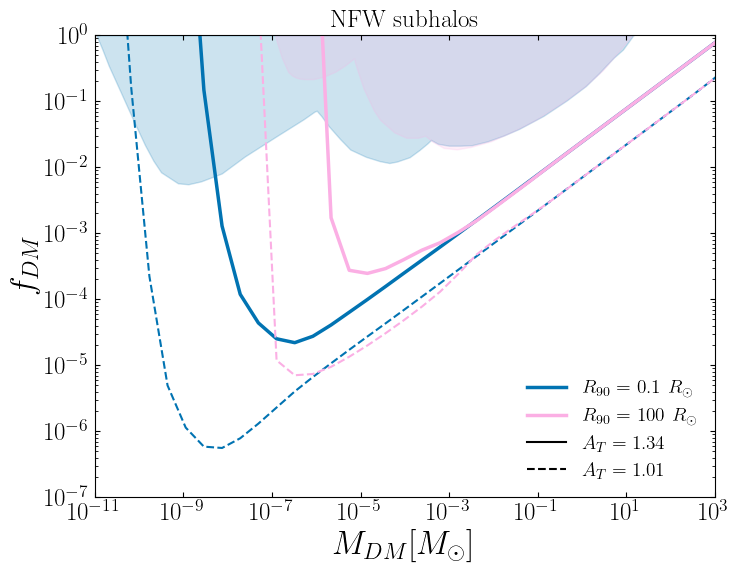

In [149]:
#New R90 Implementation longer t_dur
R90_plot_vals = [0.1, 100]
for R90 in R90_plot_vals:
    plt.loglog(m_arr, fdm_dict_e[R90], label=r'$R_{90} =$ ' + str(R90) + '$ ~R_{\odot}$', color=color_dict[R90], linewidth=2.5)
    plt.loglog(m_arr, fdm_dict_e_101[R90], color=color_dict[R90], ls='--')

plt.plot(0, 0, color='k', label=r'$A_T = 1.34$')
plt.plot(0, 0, ls='--', color='k', label=r'$A_T = 1.01$')

plot_existing_limits()
plt.ylim(1e-7, 1)
plt.xlim(1e-11, 1e3)
plt.legend()
plt.xlabel('$M_{DM} [M_{\odot}]$')
plt.ylabel('$f_{DM}$')
plt.title('NFW subhalos')
# plt.savefig('figures/extended_limits_e_101.pdf')
plt.show()

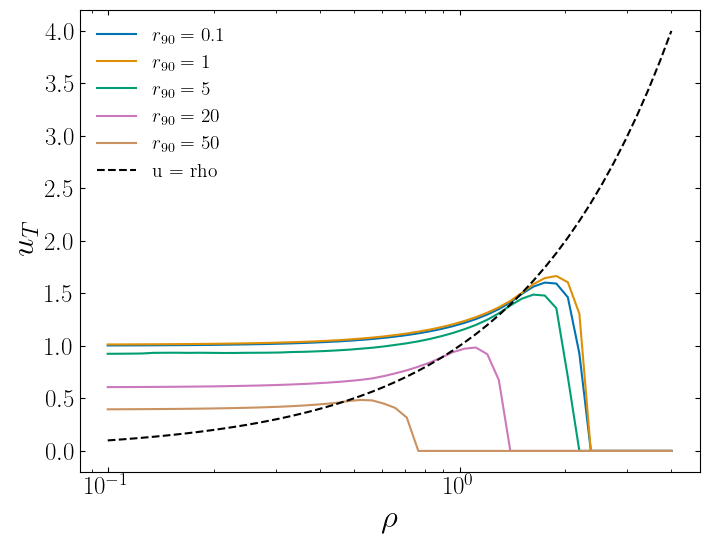

In [119]:
r90_plot_vals = [0.1,1, 5, 20, 50]
rho_arr = np.logspace(-1, np.log10(4), 50)

for r90 in r90_plot_vals:
    ut_arr = np.array([u_t_nfw(rho, r90) for rho in rho_arr])
    plt.plot(rho_arr, ut_arr, label=r'$r_{90} =$ ' + str(r90), color=color_dict[r90])

# plt.plot(rho_arr, u_T_arr_01, label=r'$r_{90} = 0.1$')
# plt.plot(rho_arr, u_T_arr_10, label=r'$r_{90} = 10$')
# plt.plot(rho_arr, u_T_arr_100, label=r'$r_{90} = 100$')
plt.plot(rho_arr, rho_arr, label='u = rho', ls='--', color='k')
plt.xscale('log')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$u_T$')
# plt.ylim(0,4)
plt.legend()
# plt.savefig('figures/u_T_extended.pdf')
plt.show()

### Axion

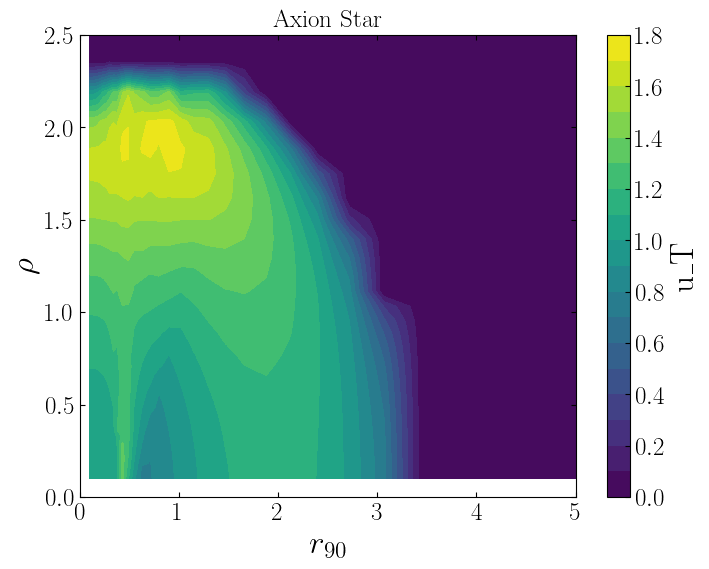

In [138]:
u_T_values_axion = np.zeros((len(rho_arr), len(r90_vals_axion)))

for i, r90 in enumerate(r90_vals_axion):
    for j, rho in enumerate(rho_arr):
        u_T_values_axion[j, i] = u_t_axion(rho, r90)

# Creating the contour plot
X, Y = np.meshgrid(r90_vals_axion, rho_arr)
plt.contourf(X, Y, u_T_values_axion, levels=20, cmap='viridis')
plt.colorbar(label='u_T')
# plt.xscale('log')
plt.xlabel(r'$r_{90}$')
plt.ylabel(r'$\rho$')
plt.title('Axion Star')
plt.ylim(0,2.5)
plt.xlim(0,5)
plt.show()

In [17]:
m_arr = np.logspace(-11, 4, 100)

rate_dict_axion = {}

R90_values_axion = [0.1, 1, 10]
for R90 in tqdm(R90_values_axion):
    func = partial(calculate_rate, R90=R90, u_t_func=u_t_axion)
    with Pool() as pool:
        rate_arr = np.array(pool.map(func, m_arr))
    
    rate_dict_axion[R90] = rate_arr

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [03:22<00:00, 67.60s/it]


In [18]:
rate_dict_axion_101 = {}

for R90 in tqdm(R90_values_axion):
    func = partial(calculate_rate, R90=R90, u_t_func=u_t_axion_101)
    with Pool() as pool:
        rate_arr = np.array(pool.map(func, m_arr))
    rate_dict_axion_101[R90] = rate_arr

100%|██████████| 3/3 [03:41<00:00, 73.92s/it]


In [19]:
fdm_dict_axion = {}

for R90, rate_arr in rate_dict_axion.items():
    fdm_arr = fdm_constraint(rate_arr, params['obs_time'], params['n_sources'])
    fdm_dict_axion[R90] = fdm_arr

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_67666/614136275.py:2: RuntimeWarning: divide by zero encountered in divide
  fdm = 3.0 / (rate*obs_time*n_sources)


In [20]:
fdm_dict_axion_101 = {}

for R90, rate_arr in rate_dict_axion_101.items():
    fdm_arr = fdm_constraint(rate_arr, params['obs_time'], params['n_sources'])
    fdm_dict_axion_101[R90] = fdm_arr

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_67666/614136275.py:2: RuntimeWarning: divide by zero encountered in divide
  fdm = 3.0 / (rate*obs_time*n_sources)


In [45]:
R90_01_axion_df = pd.read_csv('extended_dat/R90_01_axion.csv', header=None)
R90_1_axion_df = pd.read_csv('extended_dat/R90_1_axion.csv', header=None)
R90_10_axion_df = pd.read_csv('extended_dat/R90_10_axion.csv', header=None)

def plot_existing_limits_axion(ax=None):
    if not ax:
        ax = plt.gca()
    ax.fill_between(R90_01_axion_df[0], R90_01_axion_df[1], 1, alpha=0.2, color=color_dict[0.1])
    ax.fill_between(R90_1_axion_df[0], R90_1_axion_df[1], 1, alpha=0.2, color=color_dict[1])
    ax.fill_between(R90_10_axion_df[0], R90_10_axion_df[1], 1, alpha=0.2, color=color_dict[10])

    # plt.fill_between(R90_01_axion_df[0], R90_01_axion_df[1], 1, alpha=0.2, color=color_dict[0.1])
    # plt.fill_between(R90_1_axion_df[0], R90_1_axion_df[1], 1, alpha=0.2, color=color_dict[1])
    # plt.fill_between(R90_10_axion_df[0], R90_10_axion_df[1], 1, alpha=0.2, color=color_dict[10])
    

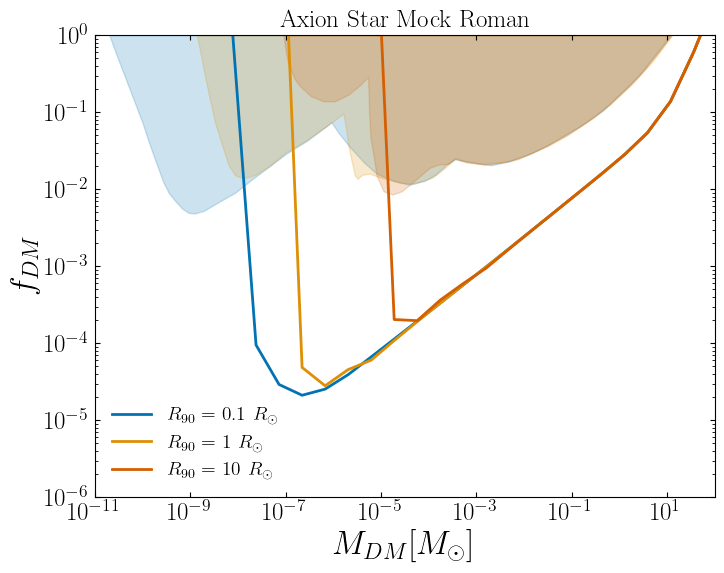

In [132]:
r90_plot_vals = [0.1, 1, 4]
for R90 in R90_values_axion:
    plt.loglog(m_arr, fdm_dict_axion[R90], label=r'$R_{90} =$ ' + str(R90) + '$ ~R_{\odot}$', color=color_dict[R90], linewidth=2)

# plt.plot(0, 0, ls='--', color='k', label='Existing Limits')
# plt.plot(0, 0, color='k', label='This Work')
plot_existing_limits_axion()
plt.ylim(1e-6, 1)
plt.xlim(1e-11, 1e2)
plt.legend()
plt.xlabel('$M_{DM} [M_{\odot}]$')
plt.ylabel('$f_{DM}$')
plt.title('Axion Star Mock Roman')
# plt.savefig('figures/extended_limits_axion.pdf')
plt.show()

### Dressed Black Holes

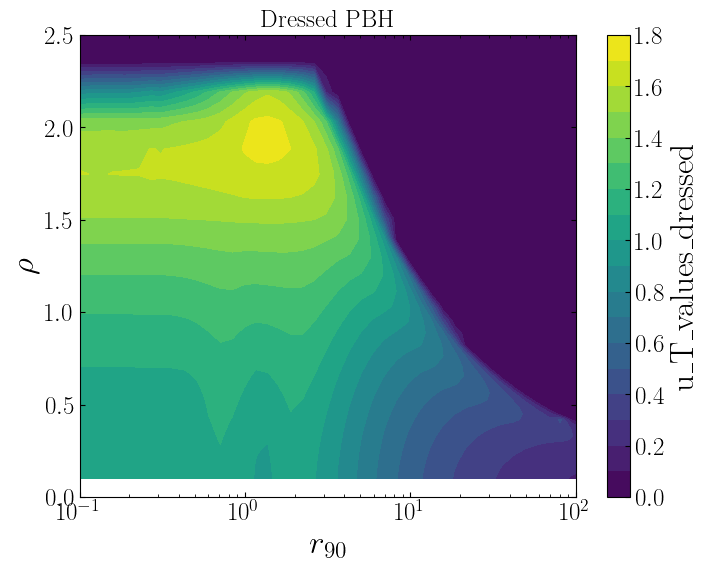

In [16]:
u_T_values_dressed = np.zeros((len(rho_arr), len(r90_vals_dressed)))

for i, r90 in enumerate(r90_vals_dressed):
    for j, rho in enumerate(rho_arr):
        u_T_values_dressed[j, i] = u_t_dressed(rho, r90)

# Creating the contour plot
X, Y = np.meshgrid(r90_vals_dressed, rho_arr)
plt.contourf(X, Y, u_T_values_dressed, levels=20, cmap='viridis')
plt.colorbar(label='u_T_values_dressed')
plt.xscale('log')
plt.xlabel(r'$r_{90}$')
plt.ylabel(r'$\rho$')
plt.title('Dressed PBH')
plt.ylim(0,2.5)
plt.xlim(1e-1,100)
plt.show()

In [22]:
m_arr = np.logspace(-11, 4, 100)

rate_dict_dressed = {}

R90_values_dressed = [0.1, 10, 100]
for R90 in tqdm(R90_values_dressed):
    func = partial(calculate_rate, R90=R90, u_t_func=u_t_dressed)
    with Pool() as pool:
        rate_arr = np.array(pool.map(func, m_arr))
    
    rate_dict_dressed[R90] = rate_arr

100%|██████████| 3/3 [03:14<00:00, 64.68s/it]


/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_67666/1992255736.py:70: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(second_integral, d_min, d_max, epsabs=epsabs, epsrel=epsrel)
/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_67666/1992255736.py:70: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, error = quad(second_integral, d_min, d_max, epsabs=epsabs, epsrel=epsrel)


In [284]:
# m_arr = np.logspace(-11, 4, 100)
# R90_values_dressed_expected = 0.019*1e-3 * (m_arr)**(1/3) * (1000/30) #in kpc

# rate_arr_dressed_expected = np.zeros(len(m_arr))

# for i, m in tqdm(enumerate(m_arr)):
#     rate_arr_dressed_expected[i] = calculate_rate_dressed(m, R90_values_dressed_expected[i], u_t_dressed)

100it [00:23,  4.18it/s]


In [23]:
rate_dict_dressed_101 = {}

for R90 in tqdm(R90_values_dressed):
    func = partial(calculate_rate, R90=R90, u_t_func=u_t_dressed_101)
    with Pool() as pool:
        rate_arr = np.array(pool.map(func, m_arr))
    rate_dict_dressed_101[R90] = rate_arr

100%|██████████| 3/3 [03:33<00:00, 71.21s/it]


In [24]:
fdm_dict_dressed = {}

for r90, rate_arr in rate_dict_dressed.items():
    fdm_arr = fdm_constraint(rate_arr, params['obs_time'], params['n_sources'])
    fdm_dict_dressed[r90] = fdm_arr

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_67666/614136275.py:2: RuntimeWarning: divide by zero encountered in divide
  fdm = 3.0 / (rate*obs_time*n_sources)


In [25]:
fdm_dict_dressed_101 = {}

for r90, rate_arr in rate_dict_dressed_101.items():
    fdm_arr = fdm_constraint(rate_arr, params['obs_time'], params['n_sources'])
    fdm_dict_dressed_101[r90] = fdm_arr

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_67666/614136275.py:2: RuntimeWarning: divide by zero encountered in divide
  fdm = 3.0 / (rate*obs_time*n_sources)


In [235]:
dpbh_df_ogle = pd.read_csv('extended_dat/Mdpbh_ogle.csv', header=None)
pbh_df_ogle = pd.read_csv('extended_dat/Mpbh_ogle.csv', header=None)
dpbh_df_hsc = pd.read_csv('extended_dat/Mdpbh_hsc.csv', header=None)
pbh_df_hsc = pd.read_csv('extended_dat/Mpbh_hsc.csv', header=None)

interp_ogle = interp1d(dpbh_df_ogle[0], dpbh_df_ogle[1], bounds_error=False, fill_value=1, kind='linear')
interp_hsc = interp1d(dpbh_df_hsc[0], dpbh_df_hsc[1], bounds_error=False, fill_value=1, kind='linear')

# Define a range of X values covering both datasets
x_min = min(dpbh_df_ogle[0].min(), dpbh_df_hsc[0].min())
x_max = max(dpbh_df_ogle[0].max(), dpbh_df_hsc[0].max())
x_range = np.geomspace(x_min, x_max, 100)  # You can adjust the number of points

# Determine the maximum Y value at each X value
y_min = np.minimum(interp_ogle(x_range), interp_hsc(x_range))


def plot_existing_limits_dpbh(ax=None):
    if not ax:
        ax = plt.gca()
    ax.fill_between(x_range, y_min, 1, alpha=0.2, color='gray')
    
    

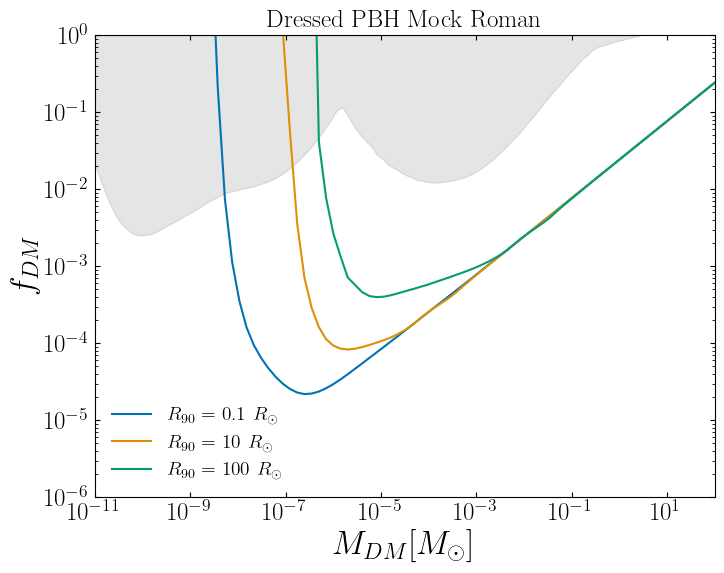

In [236]:
for R90 in R90_values_dressed:
    plt.loglog(m_arr, fdm_dict_dressed[R90], label=r'$R_{90} =$ ' + str(R90) + '$ ~R_{\odot}$')

# plt.plot(0, 0, ls='--', color='k', label='Existing Limits')
# plt.plot(0, 0, color='k', label='This Work')
plot_existing_limits_dpbh()
plt.ylim(1e-6, 1)
plt.xlim(1e-11, 1e2)
plt.legend()
plt.xlabel('$M_{DM} [M_{\odot}]$')
plt.ylabel('$f_{DM}$')
plt.title('Dressed PBH Mock Roman')
# plt.savefig('figures/extended_limits_dressed.pdf')
plt.show()

### All plots

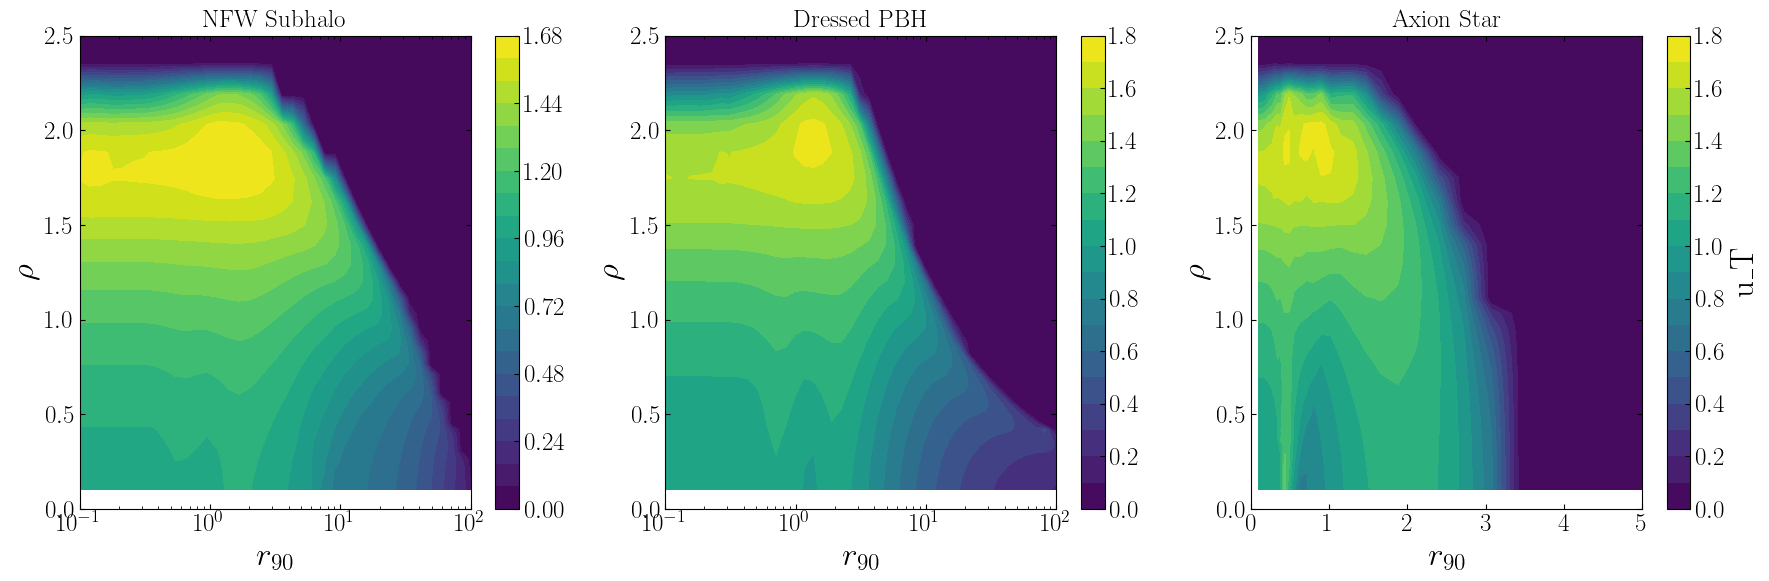

In [33]:
rho_arr = np.logspace(-1, np.log10(4), 50)

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)

u_T_values_nfw = np.zeros((len(rho_arr), len(r90_vals_nfw)))

for i, r90 in enumerate(r90_vals_nfw):
    for j, rho in enumerate(rho_arr):
        u_T_values_nfw[j, i] = u_t_nfw(rho, r90)

X, Y = np.meshgrid(r90_vals_nfw, rho_arr)
plt.contourf(X, Y, u_T_values_nfw, levels=20, cmap='viridis')
plt.colorbar()
plt.xscale('log')
plt.xlabel(r'$r_{90}$')
plt.ylabel(r'$\rho$')
plt.title('NFW Subhalo')
plt.ylim(0,2.5)
plt.xlim(1e-1,1e2)

plt.subplot(1,3,2)
u_T_values_dressed = np.zeros((len(rho_arr), len(r90_vals_dressed)))

for i, r90 in enumerate(r90_vals_dressed):
    for j, rho in enumerate(rho_arr):
        u_T_values_dressed[j, i] = u_t_dressed(rho, r90)

X, Y = np.meshgrid(r90_vals_dressed, rho_arr)
plt.contourf(X, Y, u_T_values_dressed, levels=20, cmap='viridis')
plt.colorbar()
plt.xscale('log')
plt.xlabel(r'$r_{90}$')
plt.ylabel(r'$\rho$')
plt.title('Dressed PBH')
plt.ylim(0,2.5)
plt.xlim(1e-1,100)

plt.subplot(1,3,3)
u_T_values_axion = np.zeros((len(rho_arr), len(r90_vals_axion)))

for i, r90 in enumerate(r90_vals_axion):
    for j, rho in enumerate(rho_arr):
        u_T_values_axion[j, i] = u_t_axion(rho, r90)

X, Y = np.meshgrid(r90_vals_axion, rho_arr)
plt.contourf(X, Y, u_T_values_axion, levels=20, cmap='viridis')
plt.colorbar(label='u_T')
# plt.xscale('log')
plt.xlabel(r'$r_{90}$')
plt.ylabel(r'$\rho$')
plt.title('Axion Star')
plt.ylim(0,2.5)
plt.xlim(0,5)
plt.tight_layout()
# plt.savefig('figures/u_T_all.pdf')
plt.show()

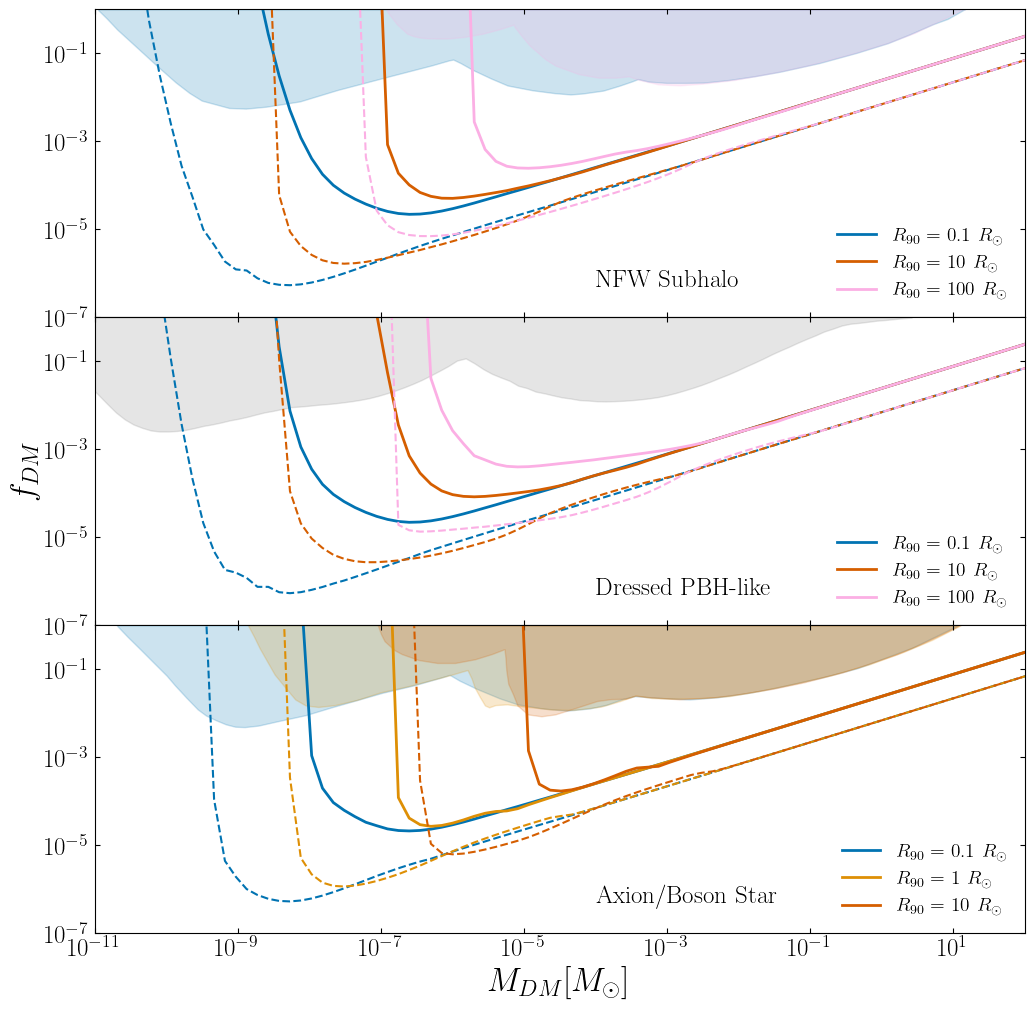

In [482]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)  # 3 rows, 1 column, sharing x-axis

# First subplot
ax = axs[0]
for R90 in R90_values:
    ax.loglog(m_arr, fdm_dict_e[R90], label=r'$R_{90} =$ ' + str(R90) + '$ ~R_{\odot}$', color=color_dict[R90], linewidth=2)
    ax.loglog(m_arr, fdm_dict_e_101[R90], color=color_dict[R90], ls='--')

plot_existing_limits(ax)
ax.text(1e-4, 5e-7, 'NFW Subhalo', fontsize=18)
ax.set_ylim(1e-7, 1)
ax.set_xlim(1e-11, 1e2)
ax.legend(loc='lower right')
# ax.set_ylabel('$f_{DM}$')

# Second subplot
ax = axs[1]
for R90 in R90_values_dressed:
    ax.loglog(m_arr, fdm_dict_dressed[R90], label=r'$R_{90} =$ ' + str(R90) + '$ ~R_{\odot}$', color=color_dict[R90], linewidth=2)
    ax.loglog(m_arr, fdm_dict_dressed_101[R90], color=color_dict[R90], ls='--')

plot_existing_limits_dpbh(ax)
ax.text(1e-4, 5e-7, 'Dressed PBH-like', fontsize=18)
ax.set_ylabel('$f_{DM}$')
ax.set_ylim(1e-7, 1)
ax.legend(loc='lower right')

# Third subplot
ax = axs[2]
for R90 in R90_values_axion:
    ax.loglog(m_arr, fdm_dict_axion[R90], label=r'$R_{90} =$ ' + str(R90) + '$ ~R_{\odot}$', color=color_dict[R90], linewidth=2)
    ax.loglog(m_arr, fdm_dict_axion_101[R90], color=color_dict[R90], ls='--')
    # ax.loglog(m_arr, m_arr**(1/2)*1e-2, color='k', ls='--', label=r'$f_{DM} \propto M^{1/2}$')

ax.text(1e-4, 5e-7, 'Axion/Boson Star', fontsize=18)
plot_existing_limits_axion()
# ax.set_ylabel('$f_{DM}$')
ax.set_ylim(1e-7, 1)
ax.legend(loc='lower right')
ax.set_xlabel('$M_{DM} [M_{\odot}]$')

fig.subplots_adjust(hspace=0.0)  # Adjust this value as needed to reduce space


# If you want to save the figure
# plt.savefig('figures/extended_limits_all.pdf')

plt.show()


### Recreate Subaru

In [573]:
# params_hsc = {"l": 121.2, "b": -21.6, "source_dist": 770, "obs_time": 7, "cadence": 0.07,  "n_sources": 8.7e7, "efficiency": 0.7, "A_t": 1.34, "survey_area":0}
params_hsc = {"l": 121.2, "b": -21.6, "source_dist": 770, "obs_time": 7, "cadence": 0.033,  "n_sources": 8.7e7, "efficiency": 0.5, "A_t": 1.34, "survey_area":0}

In [574]:
m_arr = np.logspace(-12, -3, 20)
rate_dict_hsc = {}
rS = 7.5
R90_values = [0.1, 50, 100]

for R90 in tqdm(R90_values):
    rate_arr = np.zeros_like(m_arr)
    for i, m in enumerate(m_arr):
        nfw = Nfw(m, l=params_hsc['l'], b=params_hsc['b'], ds=params_hsc['source_dist'], R90=R90*rsolkpc, rS=rS)
        rate_arr[i] = nfw.rate_mw_new(tcad=params_hsc['cadence'], tobs=params_hsc['obs_time'], efficiency=None, epsabs=0, epsrel=1e-1, v_disp=220)
    rate_dict_hsc[R90] = rate_arr

  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_32652/395398206.py:197: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(inner_integrand, u_min, u_max, args=(d), epsabs=epsabs, epsrel=epsrel)
100%|██████████| 3/3 [01:01<00:00, 20.62s/it]


In [575]:
rate_dict_hsc_m31 = {}

for R90 in tqdm(R90_values):
    rate_arr = np.zeros_like(m_arr)
    for i, m in enumerate(m_arr):
        nfw = Nfw(m, l=params_hsc['l'], b=params_hsc['b'], ds=params_hsc['source_dist'], R90=R90*rsolkpc, rS=rS)
        rate_arr[i] = nfw.rate_m31_new(tcad=params_hsc['cadence'], tobs=params_hsc['obs_time'], efficiency=None, epsabs=0, epsrel=1e-1, v_disp=250)
    rate_dict_hsc_m31[R90] = rate_arr

  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_32652/395398206.py:197: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, error = quad(inner_integrand, u_min, u_max, args=(d), epsabs=epsabs, epsrel=epsrel)
100%|██████████| 3/3 [01:01<00:00, 20.65s/it]


In [580]:
fdm_dict_hsc = {}

for R90 in R90_values:
    rate_arr = rate_dict_hsc[R90] + rate_dict_hsc_m31[R90]
    fdm_arr = fdm_constraint(rate_arr, params_hsc['obs_time'], params_hsc['n_sources'])
    fdm_dict_hsc[R90] = fdm_arr

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_32652/1587861707.py:2: RuntimeWarning: divide by zero encountered in divide
  fdm = 4.74/ (rate*obs_time*n_sources)


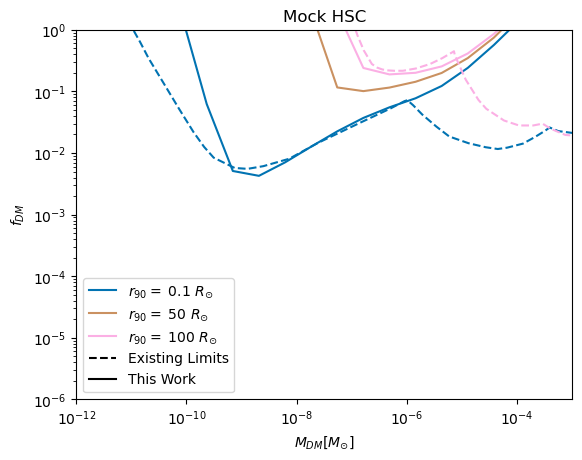

In [581]:
#vdisp 220, 250 7.5 rSol NEW R90 Implementation
R90_plot_vals = [0.1, 50, 100]
for R90 in R90_plot_vals:
    plt.loglog(m_arr, fdm_dict_hsc[R90]/params_hsc['efficiency'], label=r'$r_{90} =$ ' + str(R90) + '$ ~R_{\odot}$', color=color_dict[R90])
plot_existing_limits()
plt.plot(0, 0, ls='--', color='k', label='Existing Limits')
plt.plot(0, 0, color='k', label='This Work')
plt.ylim(1e-6, 1)
plt.xlim(1e-12, 1e-3)
plt.legend()
plt.xlabel('$M_{DM} [M_{\odot}]$')
plt.ylabel('$f_{DM}$')
plt.title('Mock HSC')
# plt.savefig('figures/extended_limits_e.pdf')
plt.show()

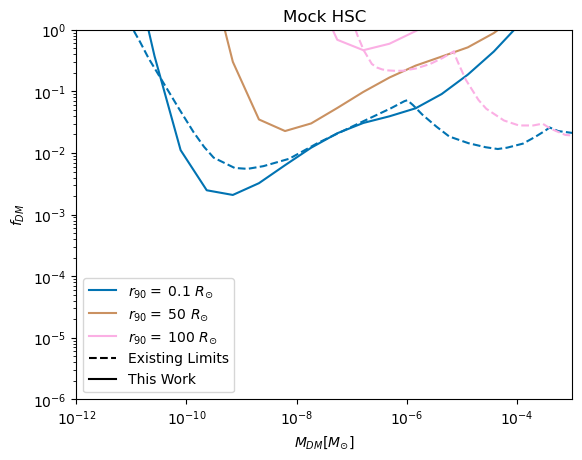

In [72]:
#vdisp 220, 250 7.5 rSol
r90_plot_vals = [0.1, 50, 100]
for r90 in r90_plot_vals:
    plt.loglog(m_arr, fdm_dict_hsc[r90]/params_hsc['efficiency'], label=r'$r_{90} =$ ' + str(r90) + '$ ~R_{\odot}$', color=color_dict[r90])
plot_existing_limits()
plt.plot(0, 0, ls='--', color='k', label='Existing Limits')
plt.plot(0, 0, color='k', label='This Work')
plt.ylim(1e-6, 1)
plt.xlim(1e-12, 1e-3)
plt.legend()
plt.xlabel('$M_{DM} [M_{\odot}]$')
plt.ylabel('$f_{DM}$')
plt.title('Mock HSC')
# plt.savefig('figures/extended_limits_e.pdf')
plt.show()

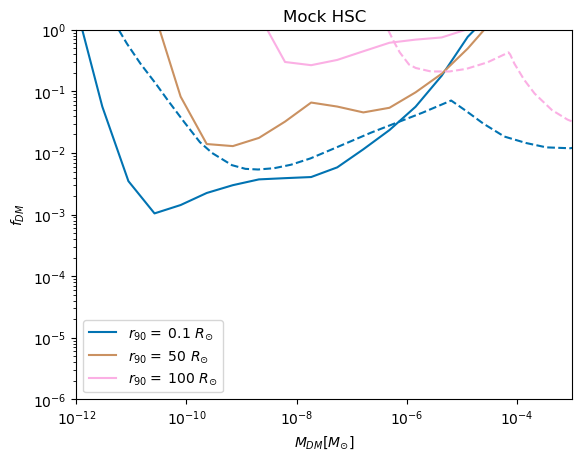

In [52]:
#vdisp nfw
r90_plot_vals = [0.1, 50, 100]
for r90 in r90_plot_vals:
    plt.loglog(m_arr, fdm_dict_hsc[r90]/params_hsc['efficiency'], label=r'$r_{90} =$ ' + str(r90) + '$ ~R_{\odot}$', color=color_dict[r90])
plot_existing_limits()
# plt.plot(0, 0, ls='--', color='k', label='Existing Limits')
# plt.plot(0, 0, color='k', label='This Work')
plt.ylim(1e-6, 1)
plt.xlim(1e-12, 1e-3)
plt.legend()
plt.xlabel('$M_{DM} [M_{\odot}]$')
plt.ylabel('$f_{DM}$')
plt.title('Mock HSC')
# plt.savefig('figures/extended_limits_e.pdf')
plt.show()

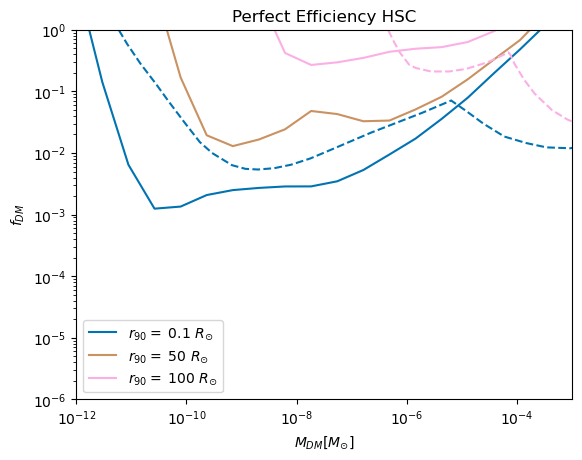

In [173]:
r90_plot_vals = [0.1, 50, 100]
for r90 in r90_plot_vals:
    plt.loglog(m_arr, fdm_dict_hsc[r90]/params_hsc['efficiency'], label=r'$r_{90} =$ ' + str(r90) + '$ ~R_{\odot}$', color=color_dict[r90])
plot_existing_limits()
# plt.plot(0, 0, ls='--', color='k', label='Existing Limits')
# plt.plot(0, 0, color='k', label='This Work')
plt.ylim(1e-6, 1)
plt.xlim(1e-12, 1e-3)
plt.legend()
plt.xlabel('$M_{DM} [M_{\odot}]$')
plt.ylabel('$f_{DM}$')
plt.title('Mock HSC')
# plt.savefig('figures/extended_limits_e.pdf')
plt.show()

## Generating Light Curves

### Functions

In [1]:
# Define the density profile of the extended lens, here an NFW profile with truncation radius 100 rs.
# Note that r90 = 69*rs for an NFW profile.

def rhoNFW(r, r90):
    rs = r90/69
    if 0 < r < 100*rs:
        return(((r/rs)*(1 + (r/rs))**2)**-1)
    elif r >= 100*rs:
        return(0)
    else:
        print("ERROR: r/r90 are not a valid non-negative float.")

# Define the density profile of the extended lens, here a dressed PBH profile with truncation radius 100 rs.
# Note that r90 = 86.9*rs for a dressed PBH profile.

def rhoDressedPBH(r, r90):
    rs = r90/86.9
    if 0 < r < 100*rs:
        return((r/rs)**-(9/4))
    elif r >= 100*rs:
        return(0)
    else:
        print("ERROR: r/r90 are not a valid non-negative float.")

# Define the density profile of the extended lens, here a sech^2 with truncation radius 20 rs.
# Note that r90 = rs/2.799 for a sech^2 profile.

def rhoAxion(r, r90):
    rs = r90/2.8 # 1710.04729 pg 11
    if 0 < r < 20*rs:
        return((3/(np.pi**3 * rs**3))*np.cosh(r/rs)**-1)
    elif r >= 20*rs:
        return(0)
    else:
        print("ERROR: r/r90 are not a valid non-negative float.")

# Define the density profile of the extended lens, here a sech^2 with truncation radius 20 rs.
# Note that r90 = rs/2.799 for a sech^2 profile.

def rhoSphere(r, r90):
    rs = r90/0.965
    if 0 < r < rs:
        return(1)
    elif r >= rs:
        return(0)
    else:
        print("ERROR: r/r90 are not a valid non-negative float.")

In [2]:
def M(rho, va, vb, r90, rmax):
    f = lambda vp, z: vp * rho(np.sqrt(vp**2 + z**2), r90)
    # rmax = (100/69)*r90 # nfw
    integral = dblquad(f, -rmax, rmax, va, vb)
    return(integral[0])

def Ms(rho, r90, vmin, vmax, vincrement, rmax):
    
    output = np.array([])
    vs = np.arange(vmin, vmax, vincrement)
    running_int = M(rho, 0, vmin, r90, rmax)
    for i in np.arange(len(vs)-1):
        this_int = M(rho, vs[i], vs[i+1], r90, rmax)
        running_int += this_int
        output = np.append(output, running_int)
        
    return((vs+vincrement)[0:-1], output)

#Since we don't care about the actual masses, we work in ratios with respect to the total mass.
def Mratios(rho, r90, vmin, vmax, vincrement, rmax):
    tab = Ms(rho, r90, vmin, vmax, vincrement, rmax)
    Mtot = M(rho, 0, rmax, r90, rmax)

    if rho == rhoDressedPBH:
        tab[1][:] += Mtot*0.01
        Mtot = Mtot*1.01
        return (r90, tab[0], tab[1]/Mtot)
    return(r90, tab[0], tab[1]/Mtot)
#Here, we calculate $u$ as a function of $v$. Note that the mass-ratios also have a $v$-dependence.
def u(r90, vs, Mrats):
    return(vs - vs**-1 * Mrats)
#This code checks for places in which the slope of the $u(v)$ curve flips, implying $v(u)$ is multi-valued. It then splits a given set of $u, v$ pairs into various curves corresponding to the different branches.
def signChanges(us):
    # Things are safe up to this element of the array
    usign = np.diff(np.sign(np.diff(us)))
    flipidxs = np.nonzero(usign)[0]+1
    
    return(np.append(0,np.append(flipidxs, -1)))
def splitCurves(us, vs):
    signchanges = signChanges(us)
    
    curves = []
    for i in range(len(signchanges)-1):
        ucurve = np.array(us[signchanges[i]:signchanges[i+1]])
        vcurve = np.array(vs[signchanges[i]:signchanges[i+1]])
        
        curves.append(np.array([ucurve, vcurve]))
                       
    return(curves)
        
#centerdiff is a helper function for the numerical derivative we will perform to get the magnification curve.
def centerdiff(array):
    return([array[i+1]-array[i-1] for i in range(1, len(array)-2)])
#This function performs a numerical derivative to calculate the value of the magnification for each $u, v$ pair, then returns a tuple of the corresponding $u$-values and $A$-values that allows one to construct $A_i(u)$ for each branch of solutions $i$.
def magnificationCurve(us, vs):
    return(us[1:-2], np.abs((vs[1:-2]*centerdiff(vs))/(us[1:-2]*centerdiff(us))))

In [3]:
def totalMagnificationCurve(curves, umax, nsteps):
    
    # This must be a symmetric range in order to compute negative contribution correctly.
    # umags = np.append(-np.flip(np.arange(ustep, umax, ustep)), np.arange(ustep, umax, ustep))
    
    Amags = np.array([])
    umags_unsort = np.array([])
    
    for curve in curves:
        us = curve[0]
        vs = curve[1]
        
        u1s, A1s = magnificationCurve(us, vs)
        if len(u1s) == 0:
            continue
        u1min = np.min(np.abs(u1s))
        u1max = np.max(np.abs(u1s))
        u1step = (u1max-u1min)/nsteps
        # u1mags = np.append(-np.flip(np.arange(u1min, np.min([u1max, umax]), u1step)), np.arange(u1min, np.min([u1max, umax]), u1step))
        u1mags = np.append(-np.flip(np.geomspace(u1min, np.min([u1max, umax]), nsteps)), np.geomspace(u1min, np.min([u1max, umax]), nsteps))
        
        umags_unsort = np.append(umags_unsort, u1mags)
        
    umags = np.sort(umags_unsort)
        
    loop = 0
    
    for curve in curves:
        us = curve[0]
        vs = curve[1]
        
        u1s, A1s = magnificationCurve(us, vs)
        if len(u1s) == 0:
            continue
        A1mags = np.interp(umags, u1s, A1s)
        A1mags[umags > np.max(u1s)] = 0
        A1mags[umags < np.min(u1s)] = 0
        
        if loop == 0:
            Amags = A1mags
        else:
            Amags += A1mags

        
    # We must also account for the negative image branch.
    Amagstotal = Amags + np.flip(Amags)
        
    return(umags, Amagstotal)
        
        

In [4]:
def find_uT(Athresh, umags, Amags):
    if np.max(Amags) < Athresh:
        print("A always < Athresh.")
        return(0)
    elif np.min(Amags) > Athresh:
        print("A always > Athresh.")
        return(np.inf)
    elif Amags[0] > Athresh:
        uT = umags[np.argmax(Amags < Athresh)]
    elif Amags[0] < Athresh:
        uT = umags[np.argmax(Amags > Athresh)]
    else:
        print("Error in uT computation.")
    
    return(uT)

In [18]:
def GenerateMagnificationCurve(rho, r90, vmin=0.00001, vmax=6, vstep=0.001, umax=6, nusteps=1000, AT=1.34, plot=False, save=False):
    
    if rho == rhoNFW:
        rmax = (100/69)*r90
    elif rho == rhoDressedPBH:
        rmax = (100/86.9)*r90
    elif rho == rhoAxion:
        rmax = (20/2.8)*r90
    elif rho == rhoSphere:
        rmax = r90/0.965
    else:
        print("Invalid choice of profile. Exiting.")
        return()
    
    r90, vs, Mrats = Mratios(rho, r90, vmin, vmax, vstep, rmax)
    us = u(r90, vs, Mrats)
    curves = splitCurves(us, vs)
    # print("There is/are "+str(len(curves))+" positive branch(es).") 
    
    if plot:
        fig, ax = plt.subplots(2, 1, figsize=(6,6))
        
        color = iter(plt.cm.rainbow(np.linspace(0, 1, len(curves))))
        for curve in curves:
            c = next(color)
            ax[0].plot(curve[0], curve[1], c=c)
            ax[0].plot(-np.flip(curve[0]), -np.flip(curve[1]), c=c)
            ax[0].set_ylim([-2, 2])
            ax[0].set_xlim([-3, 3])
        ax[0].set_xlabel('u')
        ax[0].set_ylabel('v')
    
    umags, Amags = totalMagnificationCurve(curves, umax, nusteps)

    uT = find_uT(AT, umags, Amags)
    # uT = find_uT(1.01, umags, Amags)

    print("u_T = "+str(np.abs(uT)))
    
    # Save output
    # np.save(rho.__name__+"_r90="+str(r90)+".npy", np.array([umags, Amags]))
    if save:
        np.save('r90_data/'+rho.__name__+"_r90="+str(r90)+".npy", np.array([umags, Amags]))

    if plot:
        ax[1].scatter(umags, Amags, s=1)
        plt.yscale('log')
        # plt.xscale('log')

        ax[1].set_xlim([-3,3])
        ax[1].set_ylim([0.9, 1e3])
        ax[1].plot([-15,15], [1.34, 1.34])
        # ax[1].plot([-15,15], [1.01, 1.01], ls='--', color='k')

        ax[1].set_xlabel('u')
        ax[1].set_ylabel('A')
    
    return(umags, Amags)

u_T = 0.9934097500076854


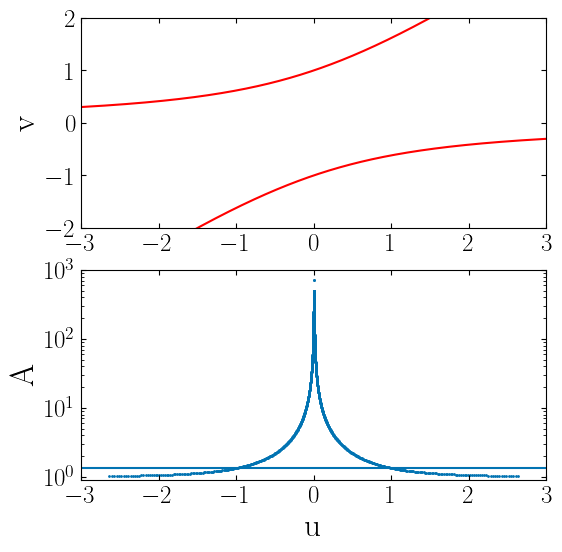

In [49]:
#axion
# umags, Amags = GenerateMagnificationCurve(rhoAxion, 0.5, vmin=0.00001, vmax=3, vstep=0.001, umax=4, nusteps=1000, AT=1.34, plot=True, save=False)
# umags6, Amags6 = GenerateMagnificationCurve(rhoAxion, 0.6, vmin=0.00001, vmax=3, vstep=0.001, umax=4, nusteps=1000, AT=1.34, plot=True, save=False)
umags0, Amags0 = GenerateMagnificationCurve(rhoAxion, 0.01, vmin=0.00001, vmax=3, vstep=0.001, umax=4, nusteps=1000, AT=1.34, plot=True, save=False)


In [28]:
np.max(Amags)

2005.021604875475

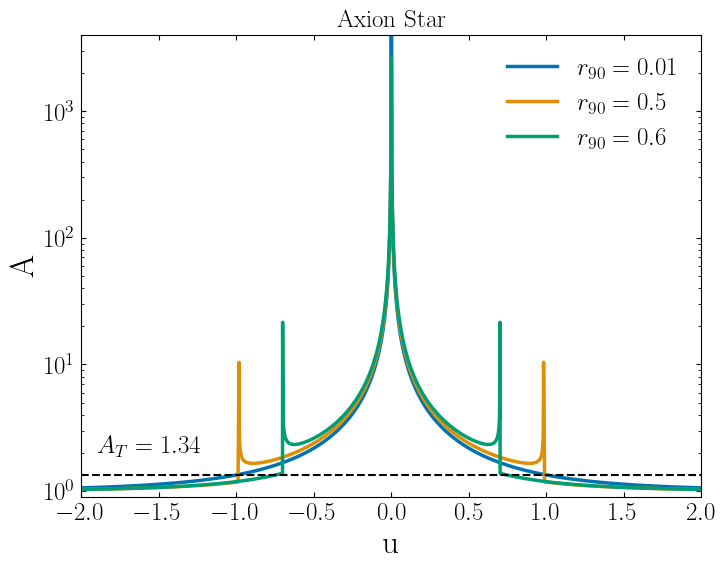

In [56]:
plt.plot(umags0, Amags0, linewidth=2.5, label=r'$r_{90} = 0.01$')
plt.plot(umags, Amags, linewidth=2.5, label=r'$r_{90} = 0.5$')
plt.plot(umags6, Amags6, linewidth=2.5, label=r'$r_{90} = 0.6$')
plt.axhline(1.34, ls='--', color='k')
plt.text(-1.9, 2.0, r'$A_T = 1.34$', fontsize=18)

plt.xlabel('u')
plt.ylabel('A')
plt.xlim(-2,2)
plt.ylim(0.9, 4e3)
plt.yscale('log')
plt.title('Axion Star')
plt.legend(fontsize=18)
# plt.savefig('figures/mag_curve_axion.pdf')
plt.show()

u_T = 0.9922123046508637


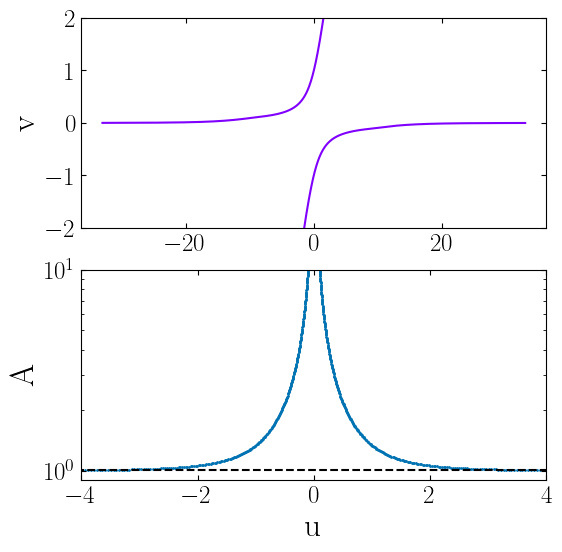

In [212]:
#w/o pbh
GenerateMagnificationCurve(rhoDressedPBH, 0.1, vmin=0.00001, vmax=6, vstep=0.001, umax=6, nusteps=1000, AT=1.34, plot=True, save=False)

u_T = 0.9891213748754543


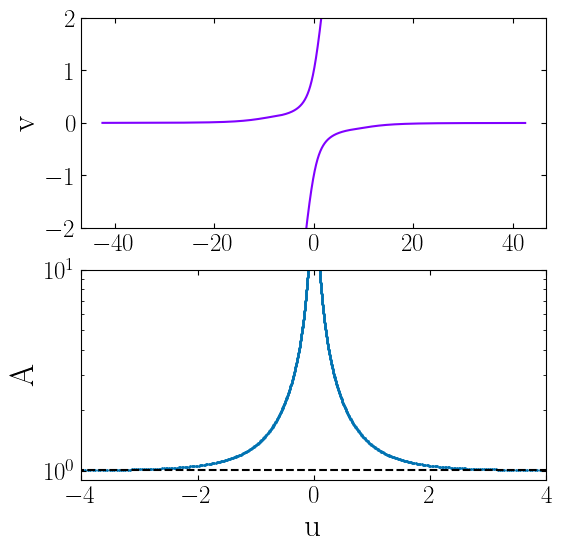

In [217]:
#w pbh
GenerateMagnificationCurve(rhoDressedPBH, 0.1, vmin=0.00001, vmax=6, vstep=0.001, umax=6, nusteps=1000, AT=1.34, plot=True, save=False)

### Generation

In [11]:
r90_vals_dressed = np.round(np.logspace(-1, np.log10(300), 50),2)
r90_vals_nfw = np.round(np.logspace(-1, np.log10(1000), 50),2)
r90_vals_axion = np.round(np.logspace(-1, np.log10(40), 50),2)


In [ ]:
def generate_wrapper_nfw(r90):
    GenerateMagnificationCurve(rhoNFW, r90, vstep=0.0005, save=True, nusteps=1000)

with Pool() as pool:
    for _ in tqdm(pool.imap(generate_wrapper_nfw, r90_vals_nfw), total=len(r90_vals_nfw)):
        pass

In [ ]:
# for r90 in tqdm(r90_vals_nfw):
#     GenerateMagnificationCurve(rhoNFW, r90, vstep=0.0005, save=True, nusteps=1000)

In [ ]:
def generate_wrapper_dressed(r90):
    GenerateMagnificationCurve(rhoDressedPBH, r90, vstep=0.0005, save=True, nusteps=1000)

with Pool() as pool:
    list(tqdm(pool.map(generate_wrapper_dressed, r90_vals_dressed), total=len(r90_vals_dressed)))

In [1589]:
# for r90 in tqdm(r90_vals_dressed):
#     GenerateMagnificationCurve(rhoDressedPBH, r90, vstep=0.0005, save=True, nusteps=1000)

100%|██████████| 50/50 [00:00<00:00, 635500.61it/s]


In [1595]:
def generate_wrapper_axion(r90):
    GenerateMagnificationCurve(rhoAxion, r90, vstep=0.0005, save=True, nusteps=1000)

with Pool() as pool:
    list(tqdm(pool.map(generate_wrapper_axion, r90_vals_axion), total=len(r90_vals_axion)))

100%|██████████| 50/50 [00:00<00:00, 373823.89it/s]


In [ ]:
# for r90 in tqdm(r90_vals_axion):
#     GenerateMagnificationCurve(rhoAxion, r90, vstep=0.0005, save=True, nusteps=1000)

 96%|█████████▌| 48/50 [37:50<02:53, 86.64s/it]

A always < Athresh.


 98%|█████████▊| 49/50 [39:25<01:28, 88.98s/it]

A always < Athresh.


100%|██████████| 50/50 [41:05<00:00, 49.30s/it]

A always < Athresh.


In [86]:
def create_functions_from_file(file_path):
    data = np.load(file_path)
    mag_interp = interp1d(data[0, :].flatten(), data[1, :].flatten(), kind='linear')
    umax = mag_interp.x[-1]
    umin = min(abs(mag_interp.x))

    def mag_wrapper(u):
        if u >= umax:
            return 1
        elif u <= -1*umax:
            return 1
        elif abs(u) < abs(umin):
            return mag_interp(umin)
        elif mag_interp(u)<1:
            return 1
        return mag_interp(u)

    def integrand_polar_fl(r, theta, u):
        x = r * np.cos(theta)
        y = r * np.sin(theta)
        return mag_wrapper(displacement(x, y, u)) * r

    def magnification_fl(u, rho):
        integrand = lambda r, theta: integrand_polar_fl(r, theta, u)

        result, _ = nquad(integrand, [[0, rho], [0, 2 * np.pi]], opts={'epsabs':0, 'epsrel':1e-1})
        return result / (np.pi * rho**2)

    def u_t_fl(rho, A_thresh=1.34):
        #! Starting from 0 where do you first drop below threshold? Make sure caustics arent defining time
        func = lambda u: magnification_fl(u, rho) - A_thresh
        u_min = 0
        u_max = 15

        try:
            return brentq(func, u_min, u_max)
        except ValueError:
            return 0

    return magnification_fl, u_t_fl

In [87]:
magnification_fl_dict_nfw = {}
u_t_fl_dict_nfw = {}

for r90 in r90_vals_nfw:
    file_path = f'r90_data/rhoNFW_r90={r90}.npy'
    magnification_fl, u_t_fl = create_functions_from_file(file_path)
    magnification_fl_dict_nfw[r90] = magnification_fl
    u_t_fl_dict_nfw[r90] = u_t_fl

magnification_fl_dict_dressed = {}
u_t_fl_dict_dressed = {}

for r90 in r90_vals_dressed:
    file_path = f'r90_data/rhoDressedPBH_r90={r90}.npy'
    magnification_fl, u_t_fl = create_functions_from_file(file_path)
    magnification_fl_dict_dressed[r90] = magnification_fl
    u_t_fl_dict_dressed[r90] = u_t_fl

magnification_fl_dict_axion = {}
u_t_fl_dict_axion = {}

for r90 in r90_vals_axion:
    file_path = f'r90_data/rhoAxion_r90={r90}.npy'
    magnification_fl, u_t_fl = create_functions_from_file(file_path)
    magnification_fl_dict_axion[r90] = magnification_fl
    u_t_fl_dict_axion[r90] = u_t_fl

In [94]:
rho_arr = np.logspace(-1, np.log10(4), 50)

# u_T_interp_funcs_nfw = {}

# # Compute u_T arrays and create interpolating functions
# for r90, u_t_fl in tqdm(u_t_fl_dict_nfw.items()):
#     func = partial(u_t_fl, A_thresh=1.34)
#     with Pool() as pool:
#         u_T_arr = np.array(list(pool.map(func, rho_arr)))
#     u_T_interp_funcs_nfw[r90] = interp1d(rho_arr, u_T_arr, kind='linear')

# u_T_interp_funcs_dressed = {}

# for r90, u_t_fl in tqdm(u_t_fl_dict_dressed.items()):
#     func = partial(u_t_fl, A_thresh=1.34)
#     with Pool() as pool:
#         u_T_arr = np.array(list(pool.map(func, rho_arr)))
#     u_T_interp_funcs_dressed[r90] = interp1d(rho_arr, u_T_arr, kind='linear')

# u_T_interp_funcs_axion = {}

# for r90, u_t_fl in tqdm(u_t_fl_dict_axion.items()):
#     func = partial(u_t_fl, A_thresh=1.34)
#     with Pool() as pool:
#         u_T_arr = np.array(list(pool.map(func, rho_arr)))
#     u_T_interp_funcs_axion[r90] = interp1d(rho_arr, u_T_arr, kind='linear')

rho_arr_101 = np.logspace(-1, np.log10(15), 50)
# u_T_interp_funcs_nfw_101 = {}

# for r90, u_t_fl in tqdm(u_t_fl_dict_nfw.items()):
#     func = partial(u_t_fl, A_thresh=1.01)
#     with Pool() as pool:
#         u_T_arr = np.array(list(pool.map(func, rho_arr_101)))
#     u_T_interp_funcs_nfw_101[r90] = interp1d(rho_arr_101, u_T_arr, kind='linear')

u_T_interp_funcs_dressed_101 = {}

for r90, u_t_fl in tqdm(u_t_fl_dict_dressed.items()):
    func = partial(u_t_fl, A_thresh=1.01)
    with Pool() as pool:
        u_T_arr = np.array(list(pool.map(func, rho_arr_101)))
    u_T_interp_funcs_dressed_101[r90] = interp1d(rho_arr_101, u_T_arr, kind='linear')

u_T_interp_funcs_axion_101 = {}

for r90, u_t_fl in tqdm(u_t_fl_dict_axion.items()):
    func = partial(u_t_fl, A_thresh=1.01)
    with Pool() as pool:
        u_T_arr = np.array(list(pool.map(func, rho_arr_101)))
    u_T_interp_funcs_axion_101[r90] = interp1d(rho_arr_101, u_T_arr, kind='linear')




100%|██████████| 50/50 [03:56<00:00,  4.73s/it]


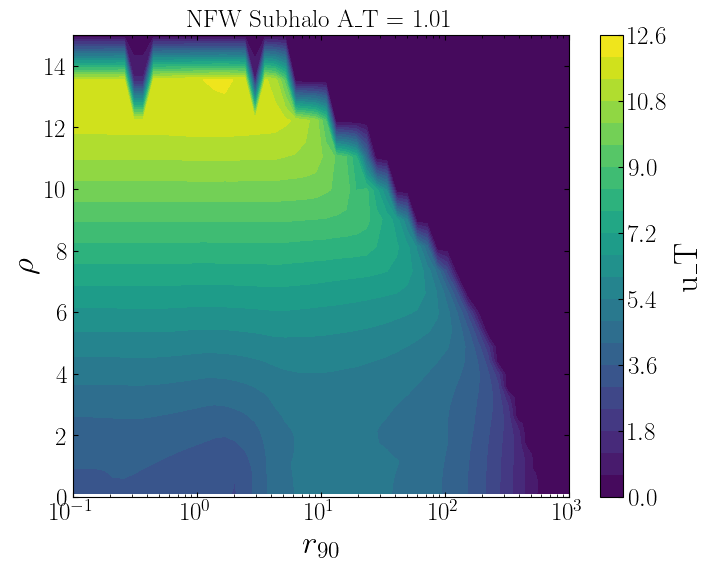

In [91]:
#new
u_T_values_nfw_101 = np.zeros((len(rho_arr_101), len(r90_vals_nfw)))

for i, r90 in enumerate(r90_vals_nfw):
    for j, rho in enumerate(rho_arr_101):
        u_T_values_nfw_101[j, i] = u_T_interp_funcs_nfw_101[r90](rho)

# Creating the contour plot
X, Y = np.meshgrid(r90_vals_nfw, rho_arr_101)
plt.contourf(X, Y, u_T_values_nfw_101, levels=20, cmap='viridis')
plt.colorbar(label='u_T')
plt.xscale('log')
plt.xlabel(r'$r_{90}$')
plt.ylabel(r'$\rho$')
plt.title('NFW Subhalo A_T = 1.01')
plt.ylim(0,15)
plt.show()

In [1566]:
uT_interp_nfw_101 = RegularGridInterpolator((rho_arr_101, r90_vals_nfw), u_T_values_nfw_101)

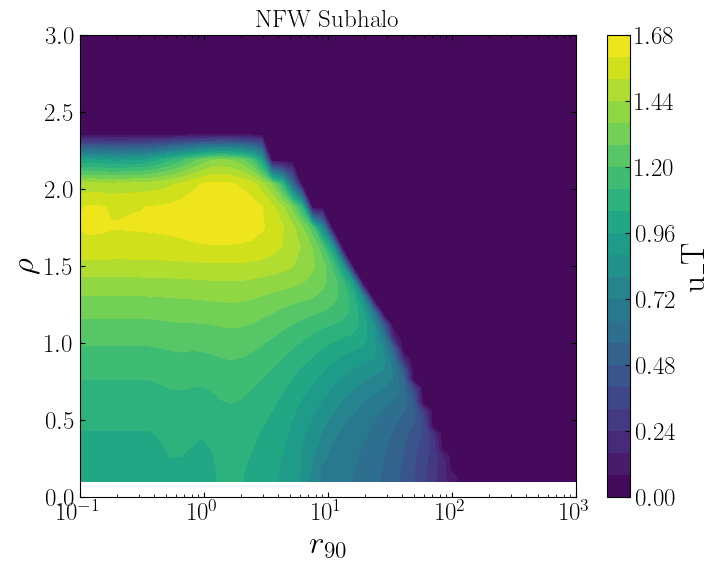

In [94]:
u_T_values_nfw = np.zeros((len(rho_arr), len(r90_vals_nfw)))

for i, r90 in enumerate(r90_vals_nfw):
    for j, rho in enumerate(rho_arr):
        u_T_values_nfw[j, i] = u_T_interp_funcs_nfw[r90](rho)

# Creating the contour plot
X, Y = np.meshgrid(r90_vals_nfw, rho_arr)
plt.contourf(X, Y, u_T_values_nfw, levels=20, cmap='viridis')
plt.colorbar(label='u_T')
plt.xscale('log')
plt.xlabel(r'$r_{90}$')
plt.ylabel(r'$\rho$')
plt.title('NFW Subhalo')
plt.ylim(0,3)
plt.show()

In [97]:
#make 2d interpolation function for u_T
uT_interp_nfw = RegularGridInterpolator((rho_arr, r90_vals_nfw), u_T_values_nfw)

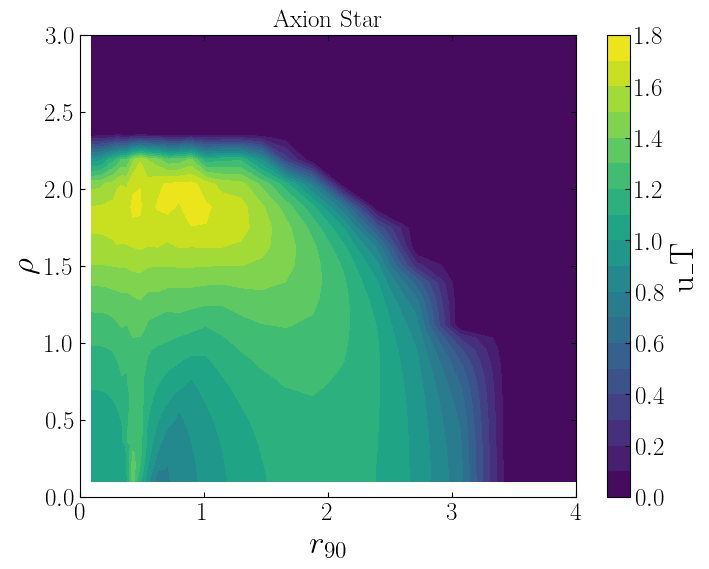

In [1614]:
u_T_values_axion = np.zeros((len(rho_arr), len(r90_vals_axion)))

for i, r90 in enumerate(r90_vals_axion):
    for j, rho in enumerate(rho_arr):
        u_T_values_axion[j, i] = u_T_interp_funcs_axion[r90](rho)

# Creating the contour plot
X, Y = np.meshgrid(r90_vals_axion, rho_arr)
plt.contourf(X, Y, u_T_values_axion, levels=20, cmap='viridis')
plt.colorbar(label='u_T')
# plt.xscale('log')
plt.xlabel(r'$r_{90}$')
plt.ylabel(r'$\rho$')
plt.title('Axion Star')
plt.ylim(0,3)
plt.xlim(0,4)
plt.show()

In [1610]:
uT_interp_axion = RegularGridInterpolator((rho_arr, r90_vals_axion), u_T_values_axion)

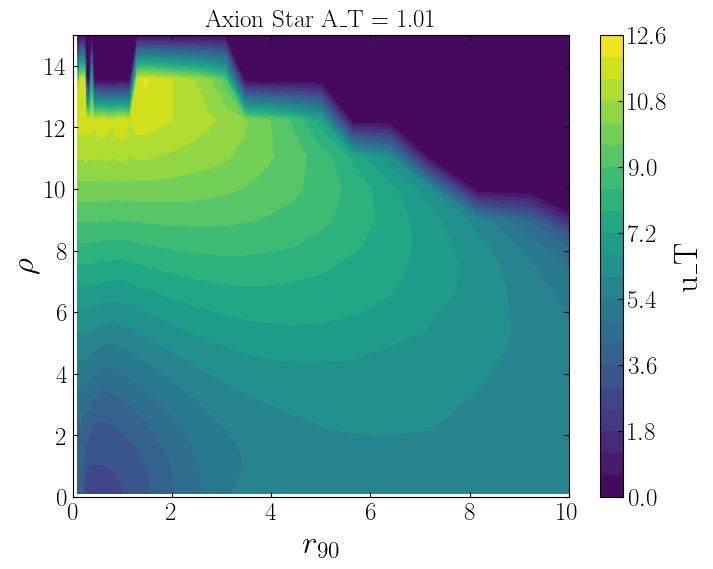

In [100]:
u_T_values_axion_101 = np.zeros((len(rho_arr_101), len(r90_vals_axion)))

for i, r90 in enumerate(r90_vals_axion):
    for j, rho in enumerate(rho_arr_101):
        u_T_values_axion_101[j, i] = u_T_interp_funcs_axion_101[r90](rho)
        
# Creating the contour plot
X, Y = np.meshgrid(r90_vals_axion, rho_arr_101)
plt.contourf(X, Y, u_T_values_axion_101, levels=20, cmap='viridis')
plt.colorbar(label='u_T')
# plt.xscale('log')
plt.xlabel(r'$r_{90}$')
plt.ylabel(r'$\rho$')
plt.title('Axion Star A_T = 1.01')
plt.ylim(0,15)
plt.xlim(0,10)
plt.show()

In [101]:
uT_interp_axion_101 = RegularGridInterpolator((rho_arr_101, r90_vals_axion), u_T_values_axion_101)

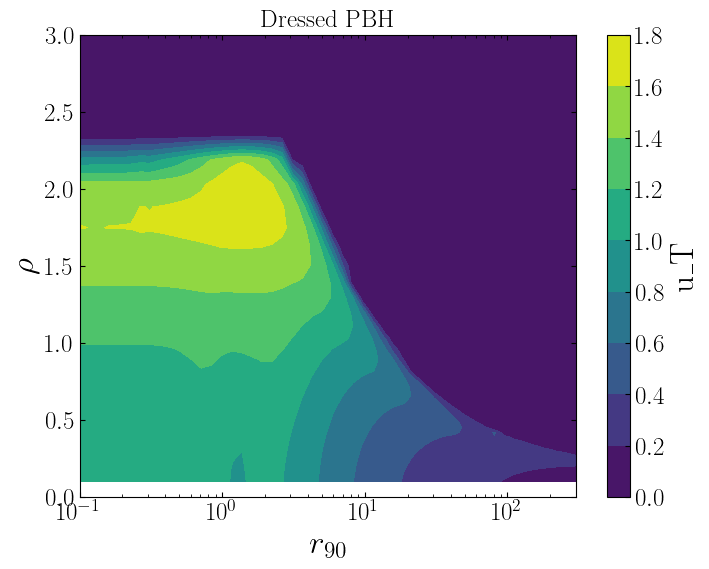

In [17]:
#w central pbh
u_T_values_dressed = np.zeros((len(rho_arr), len(r90_vals_dressed)))

for i, r90 in enumerate(r90_vals_dressed):
    for j, rho in enumerate(rho_arr):
        u_T_values_dressed[j, i] = u_T_interp_funcs_dressed[r90](rho)

# Creating the contour plot
X, Y = np.meshgrid(r90_vals_dressed, rho_arr)
plt.contourf(X, Y, u_T_values_dressed, levels=10, cmap='viridis')
plt.colorbar(label='u_T')
plt.xscale('log')
plt.xlabel(r'$r_{90}$')
plt.ylabel(r'$\rho$')
plt.title('Dressed PBH')
plt.ylim(0,3)
plt.show()

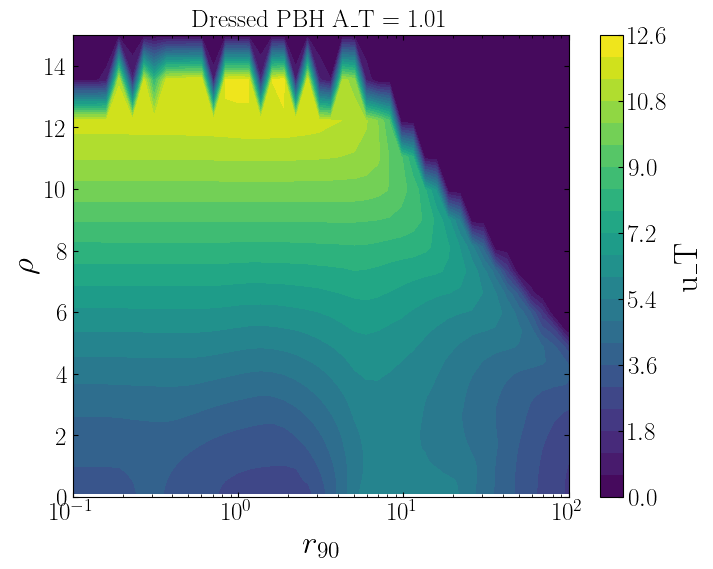

In [102]:
u_T_values_dressed_101 = np.zeros((len(rho_arr_101), len(r90_vals_dressed)))

for i, r90 in enumerate(r90_vals_dressed):
    for j, rho in enumerate(rho_arr_101):
        u_T_values_dressed_101[j, i] = u_T_interp_funcs_dressed_101[r90](rho)

X, Y = np.meshgrid(r90_vals_dressed, rho_arr_101)
plt.contourf(X, Y, u_T_values_dressed_101, levels=20, cmap='viridis')
plt.colorbar(label='u_T')
plt.xscale('log')
plt.xlabel(r'$r_{90}$')
plt.ylabel(r'$\rho$')
plt.title('Dressed PBH A_T = 1.01')
plt.ylim(0,15)
plt.xlim(1e-1,1e2)
plt.show()

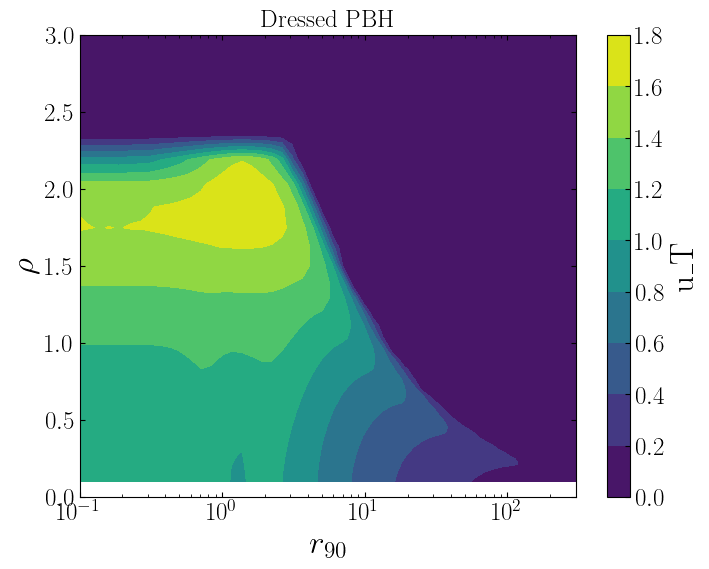

In [1611]:
u_T_values_dressed = np.zeros((len(rho_arr), len(r90_vals_dressed)))

for i, r90 in enumerate(r90_vals_dressed):
    for j, rho in enumerate(rho_arr):
        u_T_values_dressed[j, i] = u_T_interp_funcs_dressed[r90](rho)

# Creating the contour plot
X, Y = np.meshgrid(r90_vals_dressed, rho_arr)
plt.contourf(X, Y, u_T_values_dressed, levels=10, cmap='viridis')
plt.colorbar(label='u_T')
plt.xscale('log')
plt.xlabel(r'$r_{90}$')
plt.ylabel(r'$\rho$')
plt.title('Dressed PBH')
plt.ylim(0,3)
plt.show()

In [103]:
uT_interp_dressed_101 = RegularGridInterpolator((rho_arr_101, r90_vals_dressed), u_T_values_dressed_101)

In [18]:
uT_interp_dressed = RegularGridInterpolator((rho_arr, r90_vals_dressed), u_T_values_dressed)

In [104]:
# with open('../LensCalcPy/interpolations/ut_interp_nfw.pkl', 'wb') as f:
#     pickle.dump(uT_interp_nfw, f)

# with open('../LensCalcPy/interpolations/ut_interp_nfw_101.pkl', 'wb') as f:
#     pickle.dump(uT_interp_nfw_101, f)

# with open('../LensCalcPy/interpolations/ut_interp_axion.pkl', 'wb') as f:
#     pickle.dump(uT_interp_axion, f)

# with open('../LensCalcPy/interpolations/ut_interp_axion_101.pkl', 'wb') as f:
#     pickle.dump(uT_interp_axion_101, f)

# with open('../LensCalcPy/interpolations/ut_interp_dressed.pkl', 'wb') as f:
#     pickle.dump(uT_interp_dressed, f)

# with open('../LensCalcPy/interpolations/ut_interp_dressed_101.pkl', 'wb') as f:
#     pickle.dump(uT_interp_dressed_101, f)